In [2]:
import json
import datetime
from matplotlib import pyplot as plt
import pandas as pd
import requests

# Write functions

In [3]:
def gen_payload(date, origin, avg_speed, max_wind_gust): 
    date = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%dT%H:%M:%SZ')
    return [{
        "id": "urn:ngsi-ld:Impetus:windSensor:Manresa",
        "type": "WindSensor",
        "observed_at": {
            "type": "Property",
            "value": date,
            "observedAt": date,
        },      
        "origin": {
            "type": "Property",
            "value": origin,
            "observedAt": date,
        },
        "avg_speed":{
            "type": "Property",
            "value": avg_speed*1.0,
            "observedAt": date,
        },
        "max_wind_gust": {
            "type": "Property",
            "value": max_wind_gust*1.0,
            "observedAt": date,
        }        
        ,"@context": ["https://data-manager.climate-impetus.eu/schemas/WindSensor/schema.jsonld"]
    }]

def send_data(data):
    url_local = 'http://impetus-orion:1026/ngsi-ld/v1/entityOperations/upsert'
    url_remote = 'https://data-manager.climate-impetus.eu/broker/ngsi-ld/v1/entityOperations/upsert'
    response = requests.post(url=url_remote, headers={"content-type": "application/ld+json"},data=json.dumps(data))
    print(response.status_code)
    return response

# Read functions

In [4]:
def generate_read_payload(start_time, end_time):
    url = "https://data-manager.climate-impetus.eu/access/historical/entities"
    params = {
        'start_time': start_time,
        'end_time': end_time,
        'entity_type': 'windsensor',
        'format': 'COLUMN'
    }
    headers = {'accept': 'application/json'}
    response = requests.get(url, params=params, headers=headers)
    return response # print(response.json())

# Send

## Send one

In [7]:
date = '1970-01-01 00:00:00'
origin = "PROCESSED" #"DEVICE"
avg_speed = 99.0
max_wind_gust = 99.0
data = gen_payload(date, origin, avg_speed, max_wind_gust)
send_data(data)

204


<Response [204]>

## Send two

In [41]:
origin = "PROCESSED" #"DEVICE"

date_1 = '1970-01-01 00:00:00'
avg_speed_1 = 5.0
max_wind_gust_1 = 8.0

date_2 = '1970-01-02 00:00:00'
avg_speed_2 = 10.0
max_wind_gust_2 = 20.0

data_1 = gen_payload(date_1, origin, avg_speed_1, max_wind_gust_1)
data_2 = gen_payload(date_2, origin, avg_speed_2, max_wind_gust_2)
payloads = [data_1[0], data_2[0]]
payloads
# print(payloads[0] == payloads[1])
# response = send_data(payloads)
response = send_data(data_1)
response = send_data(data_2)

204
204


In [9]:
response.text

''

## Send dataframe

In [62]:
df_payload

,avg_speed,max_wind_gust
date_observed,,
1970-01-03,11.0,21.0
1970-01-05,11.0,21.0
1970-01-01,5.0,8.0
1970-01-02,10.0,20.0
1970-01-10,0.0,0.0
1970-01-08,0.0,0.0
1970-01-14,0.0,0.0
1970-01-13,0.0,0.0
1970-01-11,0.0,0.0


In [59]:
df_payload = pd.DataFrame({"avg_speed":df_response.avg_speed, "max_wind_gust":df_response.max_wind_gust}, index=df_response.index)
date_list = df_payload.index.strftime('%Y-%m-%d %H:%M:%S')
max_wind_gust_list = [99]*len(df_payload.max_wind_gust.values)
avg_speed_list = df_payload.avg_speed.values
payloads_df = [ gen_payload(date_list[i],"PROCESSED", avg_speed_list[i] ,max_wind_gust_list[i])[0] for i in range(len(date_list))]
# payloads_df
# for payload in payloads_df: send_data([payload])
# send_data(payloads_df)

In [64]:
def send_data_with_session(data, session):
    url_local = 'http://impetus-orion:1026/ngsi-ld/v1/entityOperations/upsert'
    url_remote = 'https://data-manager.climate-impetus.eu/broker/ngsi-ld/v1/entityOperations/upsert'
    response = session.post(url=url_remote, headers={"content-type": "application/ld+json"},data=json.dumps(data))
    print(response.status_code)
    return response

with requests.Session() as session:
    for payload in payloads_df:
        send_data_with_session([payload], session)

204
204
204
204
204
204
204
204
204
204


In [310]:
payloads
payloads_df
print(payloads[1] == payloads_df[1])

True


#  Read

In [25]:
response = generate_read_payload( "2017-01-01T00:00:00", "2017-02-01T00:00:00" )
# response.json()
df_response = parse_api_response_to_df(response.json())
# df_response.plot()

In [26]:
df_response

,entity_type,origin,avg_speed,max_wind_gust
date_observed,,,,
2017-01-01 12:30:00,WindSensor,PROCESSED,5.04,11.88
2017-01-02 00:00:00,WindSensor,PROCESSED,2.16,0.00
2017-01-03 03:20:00,WindSensor,PROCESSED,3.96,15.12
2017-01-04 13:40:00,WindSensor,PROCESSED,5.04,18.00
2017-01-05 04:50:00,WindSensor,PROCESSED,3.96,15.12
2017-01-09 12:40:00,WindSensor,PROCESSED,6.84,20.88
2017-01-06 00:00:00,WindSensor,PROCESSED,3.96,10.08
2017-01-08 16:50:00,WindSensor,PROCESSED,3.96,18.00
2017-01-10 22:40:00,WindSensor,PROCESSED,5.04,14.04


In [8]:
response = generate_read_payload( df_payload.sort_index().index[0],  df_payload.sort_index().index[-1])
# response.json()
df_response = parse_api_response_to_df(response.json())
df_response

NameError: name 'df_payload' is not defined

In [440]:
response.json()['urn:ngsi-ld:Impetus:windSensor:Manresa']['origin']

['DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',
 'DEVICE',

In [20]:
response = generate_read_payload( '1970-01-01T00:00:00',  '1971-01-02T00:00:00')
response.json()
# print(json.dumps(response.json(), indent=2))

{'urn:ngsi-ld:Impetus:windSensor:Manresa': {'entity_type': 'WindSensor',
  'date_observed': ['1970-01-01T00:00:00',
   '1970-01-01T00:00:00',
   '1970-01-01T00:00:00',
   '1970-01-03T00:00:00',
   '1970-01-03T00:00:00',
   '1970-01-05T00:00:00',
   '1970-01-05T00:00:00',
   '1970-01-01T00:00:00',
   '1970-01-02T00:00:00',
   '1970-01-02T00:00:00',
   '1970-01-02T00:00:00',
   '1970-01-02T00:00:00',
   '1970-01-02T00:00:00',
   '1970-01-02T00:00:00',
   '1970-01-01T00:00:00',
   '1970-01-02T00:00:00',
   '1970-01-01T00:00:00',
   '1970-01-01T00:00:00',
   '1970-01-02T00:00:00',
   '1970-01-10T00:00:00',
   '1970-01-10T00:00:00',
   '1970-01-08T00:00:00',
   '1970-01-08T00:00:00',
   '1970-01-12T00:00:00',
   '1970-01-12T00:00:00',
   '1970-01-14T00:00:00',
   '1970-01-14T00:00:00',
   '1970-01-13T00:00:00',
   '1970-01-11T00:00:00',
   '1970-01-12T00:00:00',
   '1970-01-11T00:00:00',
   '1970-01-12T00:00:00',
   '1970-01-12T00:00:00'],
  'origin': ['PROCESED',
   'PROCESED',
   'PROCESE

In [2]:
def parse_api_response_to_df(payload):
    root = payload['urn:ngsi-ld:Impetus:windSensor:Manresa']
    column_names = [key for key in root.keys() if key not in ["date_observed", "entity_type", "origin"]]
    df = pd.DataFrame(root)
    df.loc[0, "avg_speed"] = 1
    df.date_observed = pd.to_datetime( df.date_observed, format="%Y-%m-%dT%H:%M:%S")
    df = df.set_index( "date_observed", drop=True )
    df = df[~df.index.duplicated( keep="last") ]
    return df

df_response = parse_api_response_to_df(response.json())

NameError: name 'response' is not defined

In [24]:
df_response

,entity_type,origin,avg_speed,max_wind_gust
date_observed,,,,
1970-01-03,WindSensor,PROCESED,11.0,21.0
1970-01-05,WindSensor,PROCESSED,11.0,21.0
1970-01-01,WindSensor,PROCESSED,5.0,8.0
1970-01-02,WindSensor,PROCESSED,10.0,20.0
1970-01-10,WindSensor,PROCESSED,0.0,0.0
1970-01-08,WindSensor,PROCESSED,0.0,0.0
1970-01-14,WindSensor,PROCESSED,0.0,0.0
1970-01-13,WindSensor,PROCESSED,0.0,0.0
1970-01-11,WindSensor,PROCESSED,0.0,0.0


# Read and plot

In [9]:
# response = generate_read_payload( '1970-01-01T00:00:00',  '2020-01-01T00:00:00')
response = generate_read_payload( '2019-01-01T00:00:00',  '2020-01-01T00:00:00')
response.json()
print(json.dumps(response.json(), indent=2))
r = response.json()

{
  "urn:ngsi-ld:Impetus:windSensor:Manresa": {
    "entity_type": "WindSensor",
    "date_observed": [
      "2019-01-01T17:30:00",
      "2019-01-02T14:40:00",
      "2019-01-03T14:20:00",
      "2019-01-04T15:40:00",
      "2019-01-05T12:40:00",
      "2019-01-06T14:10:00",
      "2019-01-07T13:50:00",
      "2019-01-08T13:30:00",
      "2019-01-09T08:50:00",
      "2019-01-10T15:40:00",
      "2019-01-11T14:00:00",
      "2019-01-12T16:10:00",
      "2019-01-13T20:20:00",
      "2019-01-14T02:30:00",
      "2019-01-15T03:50:00",
      "2019-01-16T00:00:00",
      "2019-01-17T15:20:00",
      "2019-01-18T14:00:00",
      "2019-01-19T15:50:00",
      "2019-01-20T17:20:00",
      "2019-01-21T14:30:00",
      "2019-01-22T18:20:00",
      "2019-01-23T18:10:00",
      "2019-01-24T02:30:00",
      "2019-01-25T17:10:00",
      "2019-01-26T15:20:00",
      "2019-01-27T19:20:00",
      "2019-01-28T13:30:00",
      "2019-01-29T22:30:00",
      "2019-01-30T15:30:00",
      "2019-01-31T15:10:00

In [ ]:
r

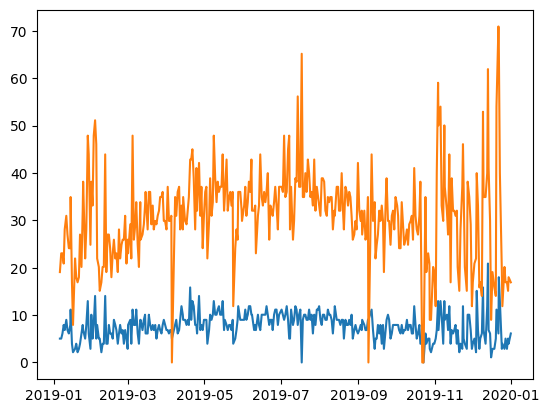

In [10]:
avg_speed = r['urn:ngsi-ld:Impetus:windSensor:Manresa']['avg_speed']
max_wind_gust = r['urn:ngsi-ld:Impetus:windSensor:Manresa']['max_wind_gust']
date_observed = r['urn:ngsi-ld:Impetus:windSensor:Manresa']['date_observed']

manresa_df = pd.DataFrame({"avg_speed":avg_speed, "max_wind_gust":max_wind_gust}, index=date_observed)
manresa_df.index = pd.to_datetime(manresa_df.index)
manresa_df = manresa_df.sort_index()[4:]
_ = plt.plot(manresa_df[['avg_speed', 'max_wind_gust']])

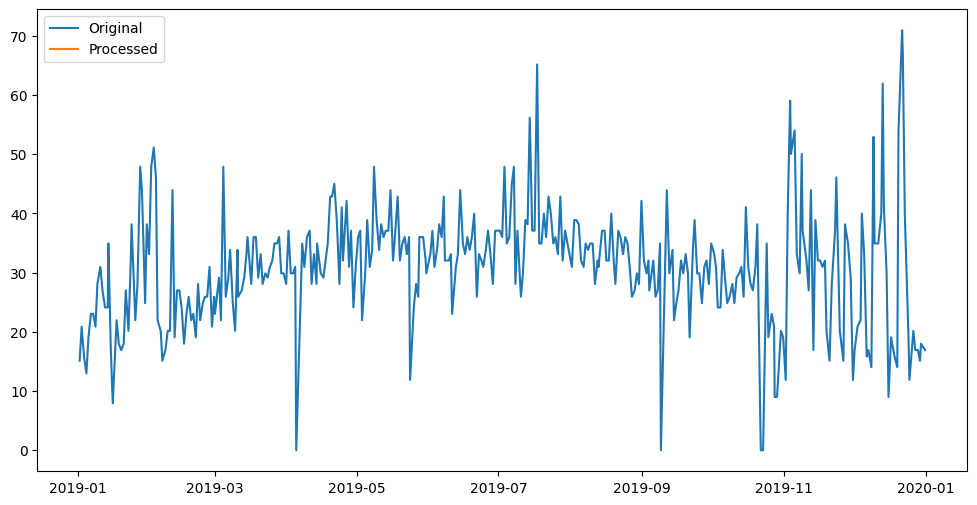

In [11]:
r = response.json()
df = pd.DataFrame(r['urn:ngsi-ld:Impetus:windSensor:Manresa'])
df.date_observed = pd.to_datetime( df.date_observed )
df = df.set_index("date_observed").drop("entity_type", axis=1)
df_device = df[ df.origin == "DEVICE"].drop("origin", axis=1)
df_processed = df[ df.origin == "PROCESSED"].drop("origin", axis=1)


plt.figure(figsize=(12,6))
_ = plt.plot(df_device[['max_wind_gust']], label="Original")
_ = plt.plot(df_processed[['max_wind_gust']], label="Processed")
_ = plt.legend()

In [12]:
df_device = df[ df.origin == "DEVICE"].drop("origin", axis=1)
df_device = df_device["2015-03-01 00:00:00":"2015-07-15 00:00:00" ]
df_device[:60]

,avg_speed,max_wind_gust
date_observed,,


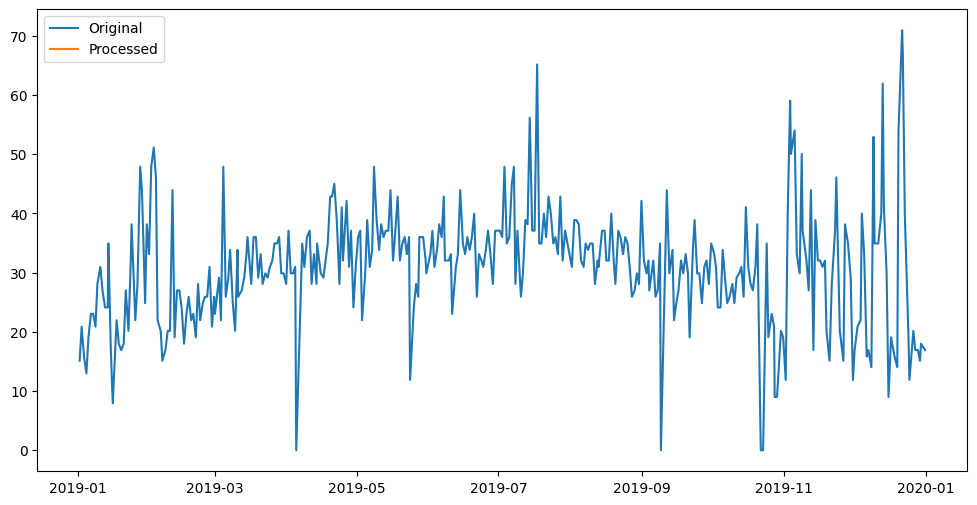

In [13]:
r = response.json()
df = pd.DataFrame(r['urn:ngsi-ld:Impetus:windSensor:Manresa'])
df.date_observed = pd.to_datetime( df.date_observed )
df = df.set_index("date_observed").drop("entity_type", axis=1)
df_device = df[ df.origin == "DEVICE"].drop("origin", axis=1)
df_processed = df[ df.origin == "PROCESSED"].drop("origin", axis=1)


plt.figure(figsize=(12,6))
_ = plt.plot(df_device[['max_wind_gust']], label="Original")
_ = plt.plot(df_processed[['max_wind_gust']], label="Processed")
_ = plt.legend()